In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle

import torch
import os
from segment_anything import sam_model_registry
import cv2
from segment_anything import SamAutomaticMaskGenerator, SamPredictor

def convert_MD_to_SAM(row):
    left = row['bbox1'] * row['width']
    top = row['bbox2'] * row['height']
    right = left + (row['bbox3'] * row['width'])
    bottom = top + (row['bbox4'] * row['height'])
    return [int(left),int(top),int(right),int(bottom)]
    
    
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)


cuda:0


In [3]:
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/home/kyra/Desktop/Models/sam_vit_h_4b8939.pth"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)
mask_predictor = SamPredictor(sam)

In [31]:
import os

segments = []

for root, dirs, files in os.walk("/home/kyra/Desktop/Data/Jaguar/Masked", topdown=False):
    for name in files:
        segments.append(os.path.join(root, name))

In [32]:
len(segments)

1283

In [34]:
trainingdata = pd.read_csv("/home/kyra/Desktop/Data/Jaguar/train.csv")
#trainingdata['local_path'] = 0

In [35]:
extra = set(segments) - set(list(trainingdata['mask_path']))

In [37]:
len(extra)

126

In [38]:
for i in extra:
    os.remove(i)

420it [16:38,  2.38s/it]


KeyboardInterrupt: 

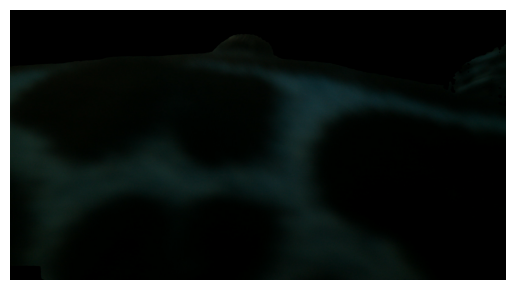

In [30]:
from tqdm import tqdm
for i, row in tqdm(trainingdata.iterrows()):
    path = row['local_path']

    maskpath = '/home/kyra/Desktop/Data/Jaguar/Masked' + row['crop_rel_path'] + \
            os.path.splitext(os.path.basename(row['crop_path']))[0] + '.png'
    
    trainingdata.loc[i,'mask_path'] = maskpath
    
    if os.path.exists(maskpath):
        continue

    image_bgr = cv2.imread(path)

    box = convert_MD_to_SAM(row)

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    mask_predictor.set_image(image_rgb)

    masks, scores, logits = mask_predictor.predict(
        box=np.array(box),
        multimask_output=False)

    m = masks.astype(np.uint8)[0]
    combined = cv2.bitwise_and(image_bgr,image_bgr,mask = m)
    crop = combined[box[1]:box[3],box[0]:box[2]]
    plt.axis('off')
    plt.imshow(crop)
    plt.savefig(maskpath, bbox_inches='tight', pad_inches=0.0)


In [ ]:
trainingdata.to_csv("/home/kyra/Desktop/Data/Jaguar/train.csv")